<a href="https://colab.research.google.com/github/madhes23/deep_learning/blob/main/MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np


# Importing and plotting samples

In [51]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

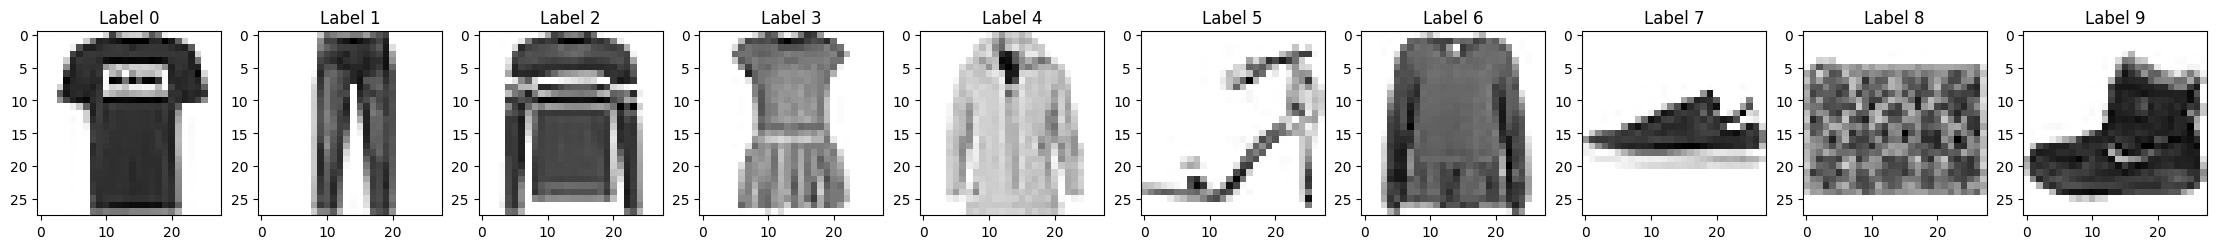

In [52]:
no_of_items = 10

fig, axes = plt.subplots(nrows = 1, ncols=10, figsize = (28, 28))
for item in range(no_of_items):
  index = 0
  while(y_train[index] != item): #searching for the first occurance of the element
    index = index+1
  
  ax = axes[item]
  ax.imshow(x_train[index], cmap='gray_r')
  ax.set_title('Label {}'.format(item))


# Forward Propogation

In [64]:

class Classification:
    no_of_class = None
    hidden_layer = None
    input_layer = None
    activation_func = None
    max_iterations = None
    weight = []
    bias = []
    def __init__(self, _no_of_class, _hidden_layer, _input_layer, _activation_fun, _max_iterations = 1000) -> None:
        self.no_of_class = _no_of_class
        self.hidden_layer = _hidden_layer
        self.activation_func = _activation_fun
        self.max_iterations = _max_iterations
        self.input_layer = _input_layer


    def set_weight_and_bias(self):
        #appending all these in a single list (easy for initializing w and b)
        layer = [self.input_layer]
        layer = layer + self.hidden_layer
        layer.append(self.no_of_class)

        #going to use 1-based indexing (as tought in the class)
        #so adding some random matrix in 0-th index
        w = [np.random.rand(1,1)]
        b = [np.random.rand(1,1)]

        i = 1
        while i < len(layer):
            w.append(np.random.rand(layer[i], layer[i-1]))
            b.append(np.random.rand(layer[i]))
            i +=1
        
        return w, b


    def activation_function(self, a):
        if(self.activation_func == 0): #sigmoid
            return 1/1+np.exp(-a)


    def output_function(self, a):
        temp = np.exp(a)
        sum = temp.sum()
        return temp/sum


    def forward_propogation(self, input):
        #for using 1 based indexing, adding some random matrix in 0-th index
        a = [np.random.rand(1,1)]
        h = [np.random.rand(1,1)]

        a.append(self.bias[1] + np.dot(self.weight[1], input))
        
        i = 1
        while i <= len(self.hidden_layer):
            h.append(self.activation_function(a[i])) #calculating h[i]
            a.append(self.bias[i+1] + np.dot(self.weight[i+1], h[i])) #calculating a[i+1]
            i +=1
        h.append(self.output_function(a[-1]))

        return a, h

    def fit(self, x_train, y_train):
        self.weight, self.bias = self.set_weight_and_bias(self)
        
    


In [75]:
model = Classification(_no_of_class=10, _hidden_layer=[16, 16], _input_layer=784, _activation_fun=0, _max_iterations=1000)
model.weight, model.bias = model.set_weight_and_bias()
a, h = model.forward_propogation(x_train[0].reshape(784)/256)
print("Original class for the chosen image is {}".format(y_train[0]))
print("Predicted probabilities for each classes: ")

i = 0
while i < len(h[-1]):
    print("Label {}: {}".format(i, round(h[-1][i], 3)))
    i+=1

Original class for the chosen image is 9
Predicted probabilities for each classes: 
Label 0: 0.06
Label 1: 0.192
Label 2: 0.013
Label 3: 0.025
Label 4: 0.477
Label 5: 0.063
Label 6: 0.018
Label 7: 0.058
Label 8: 0.069
Label 9: 0.026


As it can be noted, the above prediction is as good as just choosing the random values